In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 36.5 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
import json

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

## Parametri BERT

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

print('BERT model selected                : ', tfhub_handle_encoder)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3


### Variabili Globali

In [7]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
data_filename = 'dataset_dantesco.csv'
train_filename = 'train_dataset_dantesco.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, data_filename))
train_data_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_bert_dante'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 
log_history = os.path.abspath(os.path.join(PATH_LOG, 'histrory.json'))

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_bert_dante'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
ita_vocab_finalname = 'ita_vocab_dante.txt'
dan_vocab_finalname = 'dan_vocab_dante.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
ita_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, ita_vocab_finalname))
dan_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, dan_vocab_finalname))

In [8]:
# parametri per il modello
ORIGINAL_COLUMN = 'Original'
TRANSLATE_COLUMN = 'Translate'

# parametri per il modello
NUM_SAMPLES = 68248 
TRAIN = 16000 
VALIDATION = 16000
N_VALIDATION = 5
TEST = 100

MAX_VOCAB_SIZE = 20000 
EMBEDDING_DIM = 64
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 5

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## DATASET

### Caricamento Dati

In [9]:
exist_data_file = Path(train_data_filenamepath)

if not exist_data_file.exists():
  # Caricamento dataset: frasi in inglese, frasi in italiano
  df = pd.read_csv(
    data_filenamepath,
    usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
    names=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
    dtype={ORIGINAL_COLUMN: str, TRANSLATE_COLUMN: str}
  )

  # df = df[-(TRAIN+VALIDATION+TEST):].reset_index(drop=True)

  # Mischio il dataset in modo che sia più uniforme tra train e test
  df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

  print(df.iloc[-4:], '\n')

  df.to_csv(train_data_filenamepath, header=False, index=False, sep='|', columns=[ORIGINAL_COLUMN, TRANSLATE_COLUMN])

In [10]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  '''
  Preprocessing dei testi di input, impostando tutti i caratteri
  minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
  qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
  (a-z, A-Z, ".", "?", "!", ",")
  '''
  w = unicode_to_ascii(w.lower().strip())

  # inserimento di uno spazio tra ogni parola e il successivo punto,
  # punto esclamativo, punto interrogativo e virgola
  # esempio: "ciao, come và?" => "ciao , come và ?"
  w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

  # sostituzione dei caratteri non desiderati con uno spazio
  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

  w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
  return w

In [11]:
df = pd.read_csv(
  train_data_filenamepath,
  usecols=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
  names=[ORIGINAL_COLUMN, TRANSLATE_COLUMN],
  sep = '|'
)

# Preprocessing dei dati di Input
input_data = df[TRANSLATE_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[ORIGINAL_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]
test_target_data = target_data[TRAIN+VALIDATION:TRAIN+VALIDATION+TEST]

print(f'Dati totali presenti nel Dataset               : {len(df)}')
print(f'Dati totali presenti nel Dataset di Train      : {len(train_input_data)}')
print(f'Dati totali presenti nel Dataset di Validation : {len(validation_input_data)}')
print(f'Dati totali presenti nel Dataset di Test       : {len(test_input_data)}\n')


print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

Dati totali presenti nel Dataset               : 68249
Dati totali presenti nel Dataset di Train      : 16000
Dati totali presenti nel Dataset di Validation : 16000
Dati totali presenti nel Dataset di Test       : 100

-----------TRAIN SET--------------
['tra esso e la base del terrapieno', 'peter ha iniziato la sua comunita senza oro . ', 'e io a lui io imparerei di piu da te ', 'con tutte le bellezze del suo spettacolo ']
['e tra l pie de la ripa ed essa , in traccia', 'pier comincio sanz oro e sanz argento , ', 'e io a lui ancor vo che mi nsegni', 'con le bellezze d ogne sua paroffia ']
-----------VALIDATION SET---------------
['era meglio che foste qui pecore o capre ! ', 'non per uscire dove non sarebbero stati bruciati . ', 'per il servizio di dio sono diventato cosi saldo , ', 'in piedi ad ascoltare con i loro occhi per terra , ']
['mei foste state qui pecore o zebe ! ', 'di non uscir dove non fosser arsi . ', 'al servigio di dio mi fe si fermo , ', 'con li occhi a terra stannos

### Analisi Dati

In [12]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Train       : {min(train_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Train       : {max(train_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Validation  : {min(validation_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Validation  : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in Italiano nel Dataset di Test        : {min(test_input_data, key = len)}')
print(f'Frase più corta in Dantesco nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in Italiano nel Dataset di Test        : {max(test_input_data, key = len)}')
print(f'Frase più lunga in Dantesco nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 16000
Frase più corta in Italiano nel Dataset di Train       : e lei , dov e ? 
Frase più corta in Dantesco nel Dataset di Train       : a vera vita non e
Frase più lunga in Italiano nel Dataset di Train       : l impatto sull ambiente e sull ambiente di lavoro e di gran lunga superiore a quello degli altri paesi . 
Frase più lunga in Dantesco nel Dataset di Train       : dal quinto il quarto , e poi dal sesto il quinto . 
---------------------------------------------------------------------------------------
Esempi nel Dataset di Validation                       : 16000
Frase più corta in Italiano nel Dataset di Validation  : e poi ho detto 
Frase più corta in Dantesco nel Dataset di Validation  : a vera vita non e
Frase più lunga in Italiano nel Dataset di Validation  : presidente . l ordine del giorno reca , in discussione congiunta , le seguenti proposte di risoluzione 
Frase più lunga in Dantesco nel Dataset di Validation  :

## Tokenizer

Creo due differenti tokenizer che mi servizranno per la predisposizione dei dati di input:


*   EncTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Encoder di Bert
*   DecTokenizer classe custom per la tokenizzazione dei dati di input al Layer di Decoder



In [13]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_ita = dataset.map(lambda ita, dan: ita)
train_dan = dataset.map(lambda ita, dan: dan)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [14]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [15]:
def cleanup_text(reserved_tokens, token_txt):

  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [16]:
tokenizers = tf.Module()

### Classe EncTokenizer

Classe custom per la tokenizzazione dei dati di Dante e che crea i tre vettori necessari al layer di Encoder 
Bert:


*   input_word_ids
*   input_type_ids
*   input_mask





In [17]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens = {
    'start_of_sequence_id': 101,
    'end_of_segment_id': 102,
    'padding_id': 0,
    'mask_id': 103
}

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [18]:
exist_vocab = Path(ita_vocab_filenamepath)

if not exist_vocab.exists():
  ita_vocab = bert_vocab.bert_vocab_from_dataset(
      train_ita.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(ita_vocab_filenamepath, ita_vocab)

In [19]:
class EncTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path, max_len):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    self.packer_input = tfm.nlp.layers.BertPackInputs(seq_length=max_len,
                                                      special_tokens_dict=reserved_tokens)
    
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings, )
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = self.packer_input([enc])
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

In [20]:
tokenizers.ita = EncTokenizer(reserved_tokens, ita_vocab_filenamepath, MAX_SEQ_LENGTH*2)

### Classe DecTokenizer

Classe custom per la tokenizzazione dei dati in lingua italiana per il layer di Decoder


In [21]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens_vocab=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens_vocab,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [22]:
exist_vocab = Path(dan_vocab_filenamepath)

if not exist_vocab.exists():
  dan_vocab = bert_vocab.bert_vocab_from_dataset(
      train_dan.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(dan_vocab_filenamepath, dan_vocab)

In [23]:
START = tf.argmax(tf.constant(reserved_tokens_vocab) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens_vocab) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape(out_type=tf.int32)[0]

  starts = tf.fill([count,1], START)
  starts = tf.cast(starts, tf.int32)

  ends = tf.fill([count,1], END)
  ends = tf.cast(ends, tf.int32)

  x = tf.concat([starts, ragged, ends], axis=1)
  return x

In [24]:
class DecTokenizer(tf.Module):
  def __init__(self, reserved_tokens_vocab, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True, token_out_type=tf.int32)
    self._reserved_tokens_vocab = reserved_tokens_vocab
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int32))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int32))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens_vocab, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens_vocab)

In [25]:
tokenizers.dan = DecTokenizer(reserved_tokens_vocab, dan_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [26]:
print(f'Vocabolario Italiano : {tokenizers.ita.get_vocab_size()}')
print(f'Vocabolario Dantesco : {tokenizers.dan.get_vocab_size()}')

Vocabolario Italiano : 5139
Vocabolario Dantesco : 6309


In [27]:
print(input_data[-2:])
print(tokenizers.ita.tokenize(input_data[-2:])['input_word_ids'][:, :32])
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.dan.tokenize(target_data[-2:]))

['in piedi sul bordo del ponte , ho visto questo', 'quindi penso di fare bene , non chiedendo nulla ']
tf.Tensor(
[[ 101   39  172  187  537   53  754    5   52   90   58  102    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 101  339 1071   37  251  151    5   38 3189  439  102    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(2, 32), dtype=int32)
------------------------------------------------------------------
['io stava sovra l ponte a veder surto , ', 'contra l disio , fo ben ch io non dimando . ']
<tf.RaggedTensor [[2, 37, 569, 206, 17, 814, 8, 152, 6086, 5, 3],
 [2, 356, 17, 268, 5, 2543, 79, 39, 37, 35, 1006, 6, 3]]>


In [28]:
print([min(train_input_data, key = len)])
print(tokenizers.ita.tokenize([min(train_input_data, key = len)])['input_word_ids'][:, :32])
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.dan.tokenize([min(train_target_data, key = len)]))

['e lei , dov e ? ']
tf.Tensor(
[[101  12 162   5 906  12   7 102   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 32), dtype=int32)
------------------------------------------------------------------
['a vera vita non e']
<tf.RaggedTensor [[2, 8, 535, 182, 35, 12, 3]]>


In [29]:
print([max(train_input_data, key = len)])
print(tokenizers.ita.tokenize([max(train_input_data, key = len)])['input_word_ids'])
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.dan.tokenize([max(train_target_data, key = len)]))

['l impatto sull ambiente e sull ambiente di lavoro e di gran lunga superiore a quello degli altri paesi . ']
tf.Tensor(
[[ 101   19   16  890 1258  442  408    8  890 1266 1389   12  408    8
   890 1266 1389   37 1240   12   37 1403  588 1895    8   92  298  159
    23  205 2389  199    6  102    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
------------------------------------------------------------------
['dal quinto il quarto , e poi dal sesto il quinto . ']
<tf.RaggedTensor [[2, 93, 1263, 45, 1420, 5, 12, 60, 93, 1148, 4

## Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [30]:
def prepare_batch(dan, ita):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int32)

  # Tokenizzo l'input per l'Encoder
  encoder = tokenizers.ita.tokenize(ita)          

  # Tokenizzo l'input per il Decder e creo la variabile Target
  dan = tokenizers.dan.tokenize(dan)
  decoder = dan[:, :-1].to_tensor()  # Drop the [END] tokens
  target = dan[:, 1:].to_tensor()   # Drop the [START] tokens
  
  decoder = tf.concat([decoder, zero], 1)
  decoder = decoder[:, :(MAX_SEQ_LENGTH)]

  target = tf.concat([target, zero], 1)
  target = target[:, :(MAX_SEQ_LENGTH)]

  return (encoder, decoder), target

In [31]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [32]:
# Suddivido il dataset di validation in n parti per effettuare una validation incrociata
num_record_validation = len(validation_input_data) / N_VALIDATION
val_input_data = []
val_target_data = []

for i in range(N_VALIDATION):
  df_input = validation_input_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]
  df_target = validation_target_data[int((i*num_record_validation)):int(((i+1)*num_record_validation))]

  val_input_data.append(df_input)
  val_target_data.append(df_target)

In [33]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = [tf.data.Dataset.from_tensor_slices((val_input, val_target)) 
                            for val_input, val_target in zip(val_input_data, val_target_data)]

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = [make_batches(val_dataset) for val_dataset in validation_dataset]

In [34]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (enc_input, dec_input), target in train_dataset.take(1):
  print('----------------------- ENCODER  -------------------------------')
  print(f'Shape                    : {enc_input["input_word_ids"].shape}')
  print(f'Word Ids                 : {enc_input["input_word_ids"][0, :MAX_SEQ_LENGTH]}')
  print(f'Input Mask               : {enc_input["input_mask"][0, :MAX_SEQ_LENGTH]}')
  print(f'Type Ids                 : {enc_input["input_type_ids"][0, :MAX_SEQ_LENGTH]}')  
  print('--------------------- DECODER ----------------------------------')
  print(f'Shape it input           : {dec_input.shape}')
  print(f'Example it input         : {dec_input[0]}')  
  print('--------------------- TARGET -----------------------------------')
  print(f'Shape it input           : {target.shape}')
  print(f'Example it target        : {target[0]}')  

----------------------- ENCODER  -------------------------------
Shape                    : (32, 128)
Word Ids                 : [ 101  243   69    8   84   75  259 2200   12   75  259 2357   99  102
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Input Mask               : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Type Ids                 : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--------------------- DECODER ----------------------------------
Shape it input           : (32, 64)
Example it input         : [   2 1736  107   36   73  573  651   12  573   52  111 4490    0    0
    0    0    0    0    0    0

## Encoder BERT

Predispondo la classe necessaria per la costruzione di BERT


In [35]:
class EncoderBert(layers.Layer):
  def __init__(self, bert_encoder, embedding_dim, max_len):
    super(EncoderBert, self).__init__()

    self.encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder', trainable=False)

    self.conv_1 = tf.keras.layers.Conv1D(embedding_dim * 4, 1, activation='relu') 
    self.conv_2 = tf.keras.layers.Conv1D(embedding_dim, 1, activation='relu') 
    self.lambda_layer = tf.keras.layers.Lambda(lambda x: x[:,:max_len])
    self.max_len = max_len

  def call(self, x, debug=False):

    if debug:
      print(f'****************** DEBUG ENCODER BERT ******************')
      print(f"First example")
      print(f'Keys                         : {list(x.keys())}')
      print(f'Shape                        : {x["input_word_ids"].shape}')
      print(f'Word Ids                     : {x["input_word_ids"][0, :16]}')
      print(f'Input Mask                   : {x["input_mask"][0, :16]}')
      print(f'Type Ids                     : {x["input_type_ids"][0, :16]}')
      
    # x = self.encoder(x)['sequence_output'] 
    # encoder_outputs stato intermedio di BERT prima che esegua la traduzione recuperare la metà della lunghezza
    x = self.encoder(x)['encoder_outputs'] 
    x = x[int(len(x) / 2) - 1]

    if debug:
      print()
      print(f'Encoder Outputs BERT Shape   : {x.shape}')
      print(f'Encoder Outputs BERT Values  : {x[0, :1, :16]}')

    x = self.conv_1(x)
    if debug:
      print()
      print(f'Sequence Conv1 Shape         : {x.shape}')

    x = self.conv_2(x)
    if debug:
      print(f'Sequence Conv2 Shape         : {x.shape}')

    x = self.lambda_layer(x)
    if debug:
      print(f'Sequence Lambda Layer        : {x.shape}')
      print()
      print(f'Sequence Outputs Values      : {x[0, 0, :16]}')      
      print('*********************************************************') 

    return x

In [36]:
encoder_bert = EncoderBert(tfhub_handle_encoder, 
                           EMBEDDING_DIM, 
                           MAX_SEQ_LENGTH)

bert_outputs = encoder_bert(enc_input, debug) 

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101  243   69    8   84   75  259 2200   12   75  259 2357   99  102
    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.2855804  -1.0893128   0.18167168 -0.51378155 -0.0605888   0.56065214
  -0.5365202   0.01175864 -0.01334048 -0.88153327 -0.1537769   0.9340685
  -0.17861578  0.3018391  -0.34964022  0.3313697 ]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 64, 64)

Sequence Outputs Values      : [0.5213613  1.7226831  0.9686215  0.         0.         0.
 0.03983971 0.33337787 0.         0.         0.         0.

## Decoder

Predispondo la classe necessaria per la costruzione di un Layer di Decoder

### TOKEN AND POSITION EMBEDDING

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras. 

In [37]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [38]:
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.dan.get_vocab_size(), EMBEDDING_DIM)

inputs_decoder = token_position_it(dec_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


### LAYER DECODER

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

#### DecodeBert

Implmentazione di un blocco di  decodifica custom per decodificare l'output dal layer EncoderBert prima di passarlo al Decoder del Transformer tramite estensione della classe Layer di Keras

In [39]:
class DecodeBert(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DecodeBert'):
    super(DecodeBert, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, bert_outputs, training=False, debug=False):
    attn_output = self.att(query=bert_outputs,
                           value=bert_outputs, 
                           key=bert_outputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(bert_outputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG DECODE-BERT *********************')
      print(f'Shape Input Layer Decode-Bert       : {bert_outputs.shape}')
      print(f'Shape Output Layer Decode-Bert      : {output.shape}')
      print('*********************************************************')

    return output

In [40]:
encoder = DecodeBert(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(bert_outputs=bert_outputs,
                          training=training, 
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************


#### Layer Decoder

In [41]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.decode_bert = DecodeBert(max_len=max_len, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=rate)
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, bert_outputs, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    dec_bert = self.decode_bert(bert_outputs=bert_outputs, training=training, debug=debug)

    attn_output2 = self.att2(key=dec_bert, 
                             value=dec_bert, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [42]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          bert_outputs=bert_outputs,  
                          training=training,
                          debug=debug)

********************* DEBUG DECODE-BERT *********************
Shape Input Layer Decode-Bert       : (32, 64, 64)
Shape Output Layer Decode-Bert      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## TRANSFORMER

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras.

In [43]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               vocab_size,
               tfhub_handle_encoder,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_dec = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)

    self.encoder = EncoderBert(tfhub_handle_encoder, embed_dim, max_len)
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    encoder_output = self.encoder(inputs_encoder, debug) 

    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder["input_word_ids"].shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    transformer_output = inputs_decoder
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           bert_outputs=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [44]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.dan.get_vocab_size(),
                               tfhub_handle_encoder,
                               DROPUOT)

transformer_output = transformer((enc_input, dec_input), 
                                 training=training,
                                 debug=debug)

****************** DEBUG ENCODER BERT ******************
First example
Keys                         : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape                        : (32, 128)
Word Ids                     : [ 101  243   69    8   84   75  259 2200   12   75  259 2357   99  102
    0    0]
Input Mask                   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids                     : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Encoder Outputs BERT Shape   : (32, 128, 768)
Encoder Outputs BERT Values  : [[-0.2855804  -1.0893128   0.18167168 -0.51378155 -0.0605888   0.56065214
  -0.5365202   0.01175864 -0.01334048 -0.88153327 -0.1537769   0.9340685
  -0.17861578  0.3018391  -0.34964022  0.3313697 ]]

Sequence Conv1 Shape         : (32, 128, 256)
Sequence Conv2 Shape         : (32, 128, 64)
Sequence Lambda Layer        : (32, 64, 64)

Sequence Outputs Values      : [0.         0.86564535 0.7597855  0.         0.06458384 0.30239856
 0.0753853  0.65765846 0.92639214 0.         0.935

In [45]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 407872    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_bert_1 (EncoderBert  multiple                 109695553 
 )                                                               
                                                                 
 DEC (Decoder)               multiple                  402912    
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  410085    
                                                 

## Addestramento modello con ottimizzatore ADAM

### Compilazione

In [46]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [47]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Create a callback Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Create a callback save the log history
json_logging_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 
                    'loss': logs['loss'],
                    'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                    'val_loss': logs['val_loss'],
                    'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

### Addestramento 1

In [ ]:
start = datetime.datetime.now()
initial_epoch = 0
epochs = EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])
  
  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/5
500/500 [==============================] - 523s 1s/step - loss: 5.4267 - sparse_categorical_accuracy: 0.7575 - val_loss: 2.4375 - val_sparse_categorical_accuracy: 0.7958
Epoch 2/5
500/500 [==============================] - 525s 1s/step - loss: 1.7939 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.3655 - val_sparse_categorical_accuracy: 0.8024
Epoch 3/5
500/500 [==============================] - 527s 1s/step - loss: 1.3541 - sparse_categorical_accuracy: 0.8082 - val_loss: 1.2219 - val_sparse_categorical_accuracy: 0.8143
Epoch 4/5
500/500 [==============================] - 519s 1s/step - loss: 1.2365 - sparse_categorical_accuracy: 0.8166 - val_loss: 1.1563 - val_sparse_categorical_accuracy: 0.8226
Epoch 5/5
500/500 [==============================] - 526s 1s/step - loss: 1.1717 - sparse_categorical_accuracy: 0.8213 - val_loss: 1.1121 - val_sparse_categorical_accuracy: 0.8262
Epoch 6/10
500/500 [==============================] - 514s 1s/step - loss: 1.1255 - sparse_categoric

### Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
initial_epoch = 24
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 25/29
500/500 [==============================] - 524s 1s/step - loss: 0.9069 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.9038 - val_sparse_categorical_accuracy: 0.8383
Epoch 26/29
500/500 [==============================] - 526s 1s/step - loss: 0.9039 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.8387
Epoch 27/29
500/500 [==============================] - 520s 1s/step - loss: 0.9000 - sparse_categorical_accuracy: 0.8393 - val_loss: 0.9000 - val_sparse_categorical_accuracy: 0.8385
Epoch 28/29
500/500 [==============================] - 520s 1s/step - loss: 0.8974 - sparse_categorical_accuracy: 0.8396 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.8385
Epoch 29/29
500/500 [==============================] - 515s 1s/step - loss: 0.8943 - sparse_categorical_accuracy: 0.8397 - val_loss: 0.8971 - val_sparse_categorical_accuracy: 0.8388
Epoch 30/34
500/500 [==============================] - 521s 1s/step - loss: 0.8923 - spars

### Addestramento 3

In [48]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [49]:
start = datetime.datetime.now()
initial_epoch = 49
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 50/54
500/500 [==============================] - 545s 1s/step - loss: 0.8568 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.8830 - val_sparse_categorical_accuracy: 0.8400
Epoch 51/54
500/500 [==============================] - 524s 1s/step - loss: 0.8557 - sparse_categorical_accuracy: 0.8433 - val_loss: 0.8827 - val_sparse_categorical_accuracy: 0.8399
Epoch 52/54
500/500 [==============================] - 526s 1s/step - loss: 0.8542 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.8831 - val_sparse_categorical_accuracy: 0.8398
Epoch 53/54
500/500 [==============================] - 524s 1s/step - loss: 0.8539 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.8833 - val_sparse_categorical_accuracy: 0.8402
Epoch 54/54
500/500 [==============================] - 527s 1s/step - loss: 0.8519 - sparse_categorical_accuracy: 0.8436 - val_loss: 0.8825 - val_sparse_categorical_accuracy: 0.8399
Epoch 55/59
500/500 [==============================] - 523s 1s/step - loss: 0.8501 - spars

### Addestramento 4

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
initial_epoch = 75
epochs = initial_epoch + EPOCHS_ADAM

for val_dataset in validation_dataset:
  json_log = open(log_history, mode='a', buffering=1, encoding='utf-8')

  transformer.fit(train_dataset,
                  initial_epoch=initial_epoch,
                  epochs=epochs,
                  shuffle=True,
                  validation_data=val_dataset,
                  callbacks=[tensorboard_callback,
                             json_logging_callback, 
                             cp_callback])

  initial_epoch = epochs
  epochs = epochs + EPOCHS_ADAM


end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

## Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

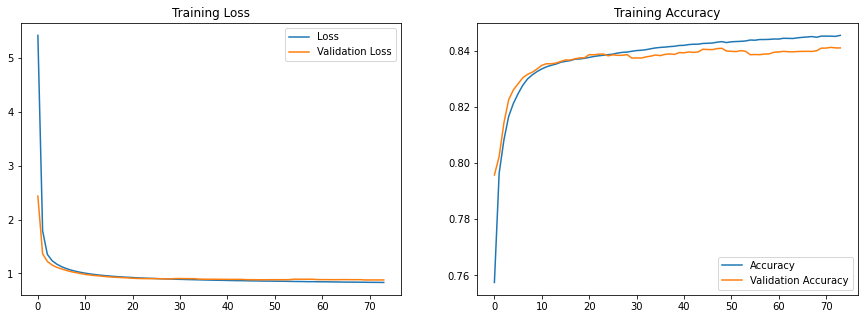

In [50]:
# Recupero il log di addestramento
df_history = pd.read_json(log_history, lines=True)

# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(df_history['loss'], label='Loss')
ax1.plot(df_history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(df_history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(df_history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [51]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [52]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    inputs_bert = self.tokenizers.ita.tokenize(input_text)

    start_end = self.tokenizers.dan.tokenize([''])[0]
    start = (start_end[0][tf.newaxis]).numpy()[0]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int32, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([start]))     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())

      transformer_output = transformer((inputs_bert, output), 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.dan.detokenize(output)[0]  
    tokens = tokenizers.dan.lookup(output)[0]

    return text, tokens

In [53]:
test_sequences = [test_input_data[2], test_input_data[26], test_input_data[19], 
                  test_input_data[34], test_input_data[45], test_input_data[58], 
                  test_input_data[62], test_input_data[71], test_input_data[84],
                  test_input_data[90], test_input_data[99], test_input_data[0]]

target_sequences = [test_target_data[2], test_target_data[26], test_target_data[19], 
                    test_target_data[34], test_target_data[45], test_target_data[58], 
                    test_target_data[62], test_target_data[71], test_target_data[84],
                    test_target_data[90], test_target_data[99], test_target_data[0]]


translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence, target in zip(test_sequences, target_sequences):
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input":15s}: {test_sequence}')
  print(f'{"Target":15s}: {target}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')


Input          : ha rivisto la sua fonte , antandros e
Target         : antandro e simeonta , onde si mosse , 
Prediction     : egli altri , che signora ,
---------------------------------------------
Input          : le creature che amano il piacere di guardare , 
Target         : queste sustanze , poi che fur gioconde
Prediction     : egli altri , egli altri ,
---------------------------------------------
Input          : quindi , tra queste tonalita , vado nella tristezza . 
Target         : per ch io vo tra costor con bassa fronte . 
Prediction     : egli spiriti che signora ,
---------------------------------------------
Input          : era un miserabile fantasma nascosto nel ghiaccio , 
Target         : mettendo i denti in nota di cicogna . 
Prediction     : egli altri , egli altri ,
---------------------------------------------
Input          : tu sei stato finche io mi sono abbassato . 
Target         : di la fosti cotanto quant io scesi 
Prediction     : e il mio capo , e la 

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720